In [722]:
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import json
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [587]:
with open("QBfantasyDF", 'rb') as picklefile: 
    df = pkl.load(picklefile)

In [698]:
# drop unneccessary columns and put dependent variable column first
finalDF = df.drop(['Name', 'Week', 'OPP'], axis=1)
col = finalDF.columns
col = [col[-2], col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[12]]
finalDF = finalDF[col]

In [700]:
# see correlation numbers
finalDF.corr()
#sns.pairplot(finalDF)

,Fantasy Points,CMP,ATT,PCT,PassYd,AvgYds/Pass,PassTD,INT,Rating,RushAtt,RushYds,AvgYds/Rush,QB Points Allowed
Fantasy Points,1.000000,0.418624,0.413010,0.427900,0.440887,0.398332,0.397824,0.109928,0.452879,0.300473,0.270769,0.273930,0.084431
CMP,0.418624,1.000000,0.970194,0.837802,0.948860,0.665755,0.756217,0.302054,0.831126,0.173103,0.079630,0.148947,-0.054603
ATT,0.413010,0.970194,1.000000,0.795460,0.924986,0.636399,0.704857,0.408728,0.766328,0.219626,0.145579,0.215090,-0.055252
PCT,0.427900,0.837802,0.795460,1.000000,0.789405,0.851100,0.609855,0.272692,0.911245,0.285669,0.164770,0.236687,-0.096066
PassYd,0.440887,0.948860,0.924986,0.789405,1.000000,0.753210,0.805153,0.199046,0.866855,0.222230,0.108940,0.183322,-0.068915
AvgYds/Pass,0.398332,0.665755,0.636399,0.851100,0.753210,1.000000,0.581318,0.077382,0.887039,0.332663,0.173591,0.234451,-0.094467
PassTD,0.397824,0.756217,0.704857,0.609855,0.805153,0.581318,1.000000,-0.000855,0.801257,0.222129,0.163815,0.211883,-0.067221
INT,0.109928,0.302054,0.408728,0.272692,0.199046,0.077382,-0.000855,1.000000,0.003880,0.156939,0.129246,0.078049,0.019739
Rating,0.452879,0.831126,0.766328,0.911245,0.866855,0.887039,0.801257,0.003880,1.000000,0.291726,0.174876,0.264119,-0.098529
RushAtt,0.300473,0.173103,0.219626,0.285669,0.222230,0.332663,0.222129,0.156939,0.291726,1.000000,0.904692,0.657412,-0.032731


In [596]:
# create variables for linear regression (test all - Lasso works best)
X=finalDF[col[1:]]
y=finalDF['Fantasy Points']
reg = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [599]:
# scale X_train and X_test data
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

In [600]:
# cross validation
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='r2')
model = reg.fit(X_train, y_train)
scores.mean()

0.24167521204241033

In [601]:
# check coefficients - which can be removed due to overfitting??
model.coef_

array([ 0.        ,  0.        ,  0.01998377,  0.04437292, -0.        ,
        0.        ,  0.        ,  0.02324679,  0.        ,  0.17849051,
        0.        ,  0.23682049])

In [660]:
# eliminate some features
X=finalDF[[col[2], col[3], col[9], col[11]]]
y=finalDF['Fantasy Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='r2')
model = reg.fit(X_train, y_train)
scores.mean()

0.17924972944633727

In [661]:
# mess around with parameters and try to find best fits
model = Lasso()
parameters = {'alpha': [1e-20, 1e-16, 1e-12], 'fit_intercept': [True,False]}
grid = GridSearchCV(model, parameters, cv=10, scoring='r2')
grid.fit(X_train_scaled, y_train)
print(grid.cv_results_)
print(grid.best_params_, grid.best_score_)

{'mean_fit_time': array([0.00236967, 0.00211201, 0.00139096, 0.00116396, 0.00089803,
       0.0008003 ]), 'std_fit_time': array([0.00076499, 0.0002948 , 0.0004847 , 0.00043914, 0.00018832,
       0.00019614]), 'mean_score_time': array([0.00041192, 0.00057921, 0.00030968, 0.00032687, 0.00031831,
       0.00030835]), 'std_score_time': array([1.21971135e-04, 3.17193680e-04, 6.01669916e-05, 1.06658944e-04,
       7.24725383e-05, 5.51863618e-05]), 'param_alpha': masked_array(data=[1e-20, 1e-20, 1e-16, 1e-16, 1e-12, 1e-12],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 1e-20, 'fit_intercept': True}, {'alpha': 1e-20, 'fit_intercept': False}, {'alpha': 1e-16, 'fit_intercept': True}, {'alpha': 1e-16, 'fit_intercept': F

In [662]:
# more cross validation
best_lasso = grid.best_estimator_
best_lasso.fit(X_train_scaled, y_train)
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='r2')
scores.mean()

0.17924972944633727

In [663]:
# test for different alphas in different degrees of complexity
score = 0
alphas = [1e-15, 1e-12, 1e-9, 1e-6, 1e-3, 1, 1e3, 1e6, 1e9]
degrees = [2, 3, 4, 5, 6, 7, 8, 9]
for alpha, degree in zip(alphas, degrees):
    est = make_pipeline(PolynomialFeatures(bestDegree), Lasso(alpha=bestAlpha))
    est.fit(X_train_scaled, y_train)
    current = est.score(X_test_scaled,y_test)
    print(current)
    if current > score:
        score = current
        bestAlpha = alpha
        bestDegree = degree
print(score, bestAlpha, bestDegree)

0.20744664101141252
0.2074466410114133
0.19919553232322296
0.19919553232322296
0.19919553232322296
0.19919553232322296
0.19919553232322296
0.19919553232322296
0.2074466410114133 1e-12 3


In [664]:
# create function to loop through
def getScore(X_train_scaled, X_test_scaled, y_train, y_test):
    est = make_pipeline(PolynomialFeatures(2), Lasso(alpha=1e-16))
    currentModel = est.fit(X_train_scaled, y_train)
    testScore = est.score(X_test_scaled,y_test)
    trainScore = est.score(X_train_scaled, y_train)
    print(trainScore, testScore)
    return (trainScore, testScore)

In [665]:
# find which columns work the best as features (up to 3 allowed)
newHigh = 0
for a in range(1,12):
    for b in range(1,12):
        print(a, b)
        for c in range(1,12):
            X=finalDF[[col[a], col[b], col[c]]]
            y=finalDF['Fantasy Points']
            reg = Lasso()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            X_train_scaled = ssX.fit_transform(X_train)
            X_test_scaled = ssX.transform(X_test)
            current = getScore(X_train_scaled, X_test_scaled, y_train, y_test)
            if current[1] > newHigh and current[1] < 0.99:
                newHigh = current[1]
                print('NEW HIGH')
                print(current)

1 1
0.22081167487488843 0.014045762447670087
NEW HIGH
(0.22081167487488843, 0.014045762447670087)
0.22235265569683804 0.019290121762979617
NEW HIGH
(0.22235265569683804, 0.019290121762979617)
0.22317409916467243 -0.008022956513706436
0.24880084883193598 -0.012070618737976435
0.24171288551139147 -0.22035520551635557
0.24016768279642875 0.059289463917689744
NEW HIGH
(0.24016768279642875, 0.059289463917689744)
0.224733678921607 0.04087213339744844
0.23804351241945898 0.029078000183221594
0.27580988019026365 -0.02441840523623262
0.27207191097210537 0.00666617867463537
0.2527214285040076 0.045532616991267094
1 2
0.22237832015862882 0.01926582399626009
0.22233165699740676 0.019218976811402055
0.2240118048099875 -0.0037307825011660967
0.2522103306854401 0.0021086696061426435
0.24214600835819522 -0.1984610429052016
0.24111502985589173 0.05833921454091717
0.23020527762236742 0.04325395869399207
0.24245591890045792 0.03181581284608048
0.2783207639646834 -0.008134153402315603
0.2773645372906689 0

0.26674846208722214 0.0632114256094245
0.24318915409656647 0.05394241668588873
2 8
0.24285783873202638 0.03179780771923513
0.23720503312997598 0.044687551990343466
0.24190353361399008 0.11811911096241168
NEW HIGH
(0.24190353361399008, 0.11811911096241168)
0.2539518411121622 -0.03113093240715625
0.24515865224155253 -0.38638513306785094
0.24260787801405204 0.03193734995697506
0.24348689403047452 0.04787681043787628
0.23720503312997598 0.04468755199034358
0.2835132583251918 -0.014857193676045544
0.2850117331323284 0.04363205279346527
0.26465760284856377 0.08357490090431852
2 9
0.2783339705967719 -0.008658680179287614
0.2628550429672274 -0.02570789309645205
0.2748797982907266 -0.029013065115507834
0.28563189227884667 -0.003079243755142791
0.27733217321342574 -0.17247987356221262
0.2786571502181501 0.02234925624987616
0.27801957398723787 0.07388721383452546
0.2835132583251918 -0.014857193676045766
0.26285504296722717 -0.025707893096452272
0.2760071436391829 -0.012695890536388088
0.270100918

0.24617098142359528 -0.01676782386955633
0.28375186291225685 -0.01566776071851339
0.2885341623408617 0.005189353464127855
0.2697823422881176 0.04202520847284896
4 5
0.25182264785447006 -0.10924522797625213
0.2559351927006853 -0.04199383357782582
0.24850185544943623 -0.19227014515677276
0.24350969948388967 -0.11753724670570455
0.24350969948388967 -0.1175372467057032
0.25472436958270894 -0.10905390400348303
0.24639344887436357 -0.0849689154687876
0.25204906356660306 -0.24840846096650337
0.2857265229578434 -0.07247881993869587
0.29108998207590975 -0.020235246026880205
0.27274567994825993 -0.011399609771863384
4 6
0.2661715478089397 -0.012131165180022219
0.2688137753266011 -0.013700722643666063
0.2520646866371178 0.03774235336521248
0.2505583071735231 0.03591974812233967
0.2547243695828081 -0.10905346202566735
0.2505583071735231 0.03591974812236287
0.25433540333087257 0.045983819414529226
0.251862320463926 0.001040076600948403
0.2896481317387066 0.0065846229563542025
0.2918682493813529 0.0

0.24134653959858152 0.06109525922017466
0.2370426534106751 0.05600372047554436
0.2395013350065931 0.09330095659669368
0.2686494935154137 -0.013626731738041187
0.24989236868749887 -0.2511233504117858
0.2370426534106751 0.056003720475544694
0.23996130475497202 0.07989857473035489
0.24260787801344785 0.03193685455798867
0.2786571502181501 0.02234925624987616
0.27375734362411897 0.027505540056155353
0.25694119505757385 0.05715359921574092
6 3
0.24211958677453582 0.05569109074160561
0.23950133500661064 0.093301126003274
0.2256815470862532 0.17391912028081258
0.2520646866420435 0.0377454233018375
0.24972485977381398 -0.10048376082609933
0.2256815470862532 0.17391912028081258
0.2396654981919396 0.13971123479184155
0.23134590944648303 0.16868128615526634
0.2717608846561551 0.089418314010548
0.2718102321112943 0.1386416267715127
0.2542169514524584 0.17249317146732812
6 4
0.2664934463982086 -0.011539383316731655
0.26909729361915824 -0.009711864716786422
0.25206468664227466 0.03774551547605287
0.

0.19333058168369943 0.1550790300223419
0.15969402115425102 0.1325234507236307
8 1
0.23804351241945887 0.029078001918332656
0.24265978636901064 0.03105992818642411
0.24384884737822066 0.05864191180234246
0.2535434962082408 -0.03450738428794553
0.24615271127230776 -0.3765011156175633
0.24413446501281266 0.034964562823570855
0.243068923793372 0.03114195909054951
0.23804351241945898 0.029078000175553172
0.2822119962997035 -0.01582197542987207
0.28545142265509527 0.03569124843186877
0.2664738266688732 0.06566480114447848
8 2
0.24294238971480442 0.030093538625541646
0.23720503312997598 0.044687551990343466
0.2419783218113445 0.11903600830272211
0.25471666131273263 -0.03443744211399147
0.2451351180915654 -0.3611708383186165
0.2426078780138219 0.03193710347260492
0.2434868940304723 0.04787681568926583
0.23720503312997598 0.04468755199034358
0.2835132583251918 -0.014857193676045988
0.2850117331323284 0.04363205279346549
0.2646576028485639 0.08357490090431852
8 3
0.24350697281175304 0.0678077475

0.28375186291225685 -0.01566776071851339
0.23661284476031297 0.0659849310620948
0.2619102141386853 -0.003312021224137318
0.20473083132115588 0.07419565974740094
0.25747515385438924 0.09981241312112998
0.14236836393110175 -0.041808224302806396
0.16656315327651772 -0.06165891730416905
0.14465960051734228 -0.03692957671167951
9 10
0.2902042113617874 -0.006340553877662636
0.2760071436391076 -0.01269592446025114
0.25723366563732175 0.0985494663758556
0.29863362099399104 0.014804296090346837
0.2541045463488304 0.09421539058955675
0.2721780518241965 0.007998453900910807
0.2197891942862077 0.0707936739933196
0.2743639920738059 0.12516145550132085
0.16656315327651772 -0.061658917312545476
0.16656315327651716 -0.06165891704269045
0.1885127374219967 -0.048476464397461116
9 11
0.2851528208309718 -0.021633676354463116
0.2701009180754813 -0.015973731114380607
0.2641203797196112 0.10807555338143948
0.29568166282627717 -0.010128463270338228
0.2567153429904241 0.06598810985601988
0.27465074029729764 -0

0.27074024073622527 0.03978627608463381
0.23507420219018615 0.10978440631552544
0.2567787397416932 0.09949421873266351
0.15969402115425124 0.1325234507236307
0.26599606787123364 0.16248279587574777
0.21407588420126467 0.0989316153764348
0.19333058168369932 0.15507903002234102
0.15969402115425102 0.1325234507236307
11 8
0.266473826668873 0.06566480131798125
0.2646576028485639 0.08357490090431874
0.24696886144097074 0.1733324562088645
0.2749654262638239 0.017627709925748913
0.26723855862971435 -0.5821003939562257
0.2576121413012774 0.13666738524113842
0.26599606787123364 0.162482795875748
0.24522964605369912 0.1698264278223206
0.2780464096441061 0.11352956022842253
0.27417506222301957 0.1466162906383056
0.24522964605369924 0.1698264278223205
11 9
0.2851528208309717 -0.021633676354461562
0.2701009180754814 -0.015973731114380607
0.2641203797196112 0.10807555338143904
0.2956816628262773 -0.01012846327033734
0.2567153429904241 0.06598810985602022
0.27465074029729764 -0.008556630810573118
0.2

In [684]:
# do the same thing as above, except this time use polynomial features (2)
newHigh = 0
for a in range(1,12):
    print(a)
    for b in range(1,12):
        print(b)
        for c in range(1,12):
            X=finalDF[[col[a], col[b], col[c]]]
            y=finalDF['Fantasy Points']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            poly = PolynomialFeatures(2, include_bias=True)
            XTrainScaled = poly.fit_transform(X_train)
            XTestScaled = poly.transform(X_test)
            model = Lasso(alpha=1e-8)
            model.fit(XTrainScaled, y_train)
            trainR = model.score(XTrainScaled, y_train)
            testR = model.score(XTestScaled, y_test)
            if testR > newHigh and testR < 0.99:
                newHigh = testR
                print('NEW HIGH')
            print(trainR, testR)

1
1
NEW HIGH
0.22081167487488843 0.014045762710746756
NEW HIGH
0.2221935028903922 0.020452217091932456
0.22317347716790514 -0.009336746024000808
0.24783569053668042 -0.0031259623281263416
0.24171288549537495 -0.22034538617526245
NEW HIGH
0.24016768278427758 0.059289218480213735
0.2247336789216062 0.040872117267694574
0.2380435054321478 0.029061995515323513
0.27580988019026387 -0.024418405974533375
0.27207191097210537 0.006666178831789993
0.2527214285040076 0.045532617242863505
2
0.22223973207012726 0.020133002571124936
0.22219724058124146 0.020466596366260248
0.22370183526729379 0.003386601880454476
0.2507305437871631 0.007359851539398221
0.2420037188867109 -0.2052571443399902
NEW HIGH
0.24093844587843727 0.060605235036691796
0.22898867325972938 0.04184727766734275
0.24231302280228173 0.03386338620520313
0.27810629190499747 -0.008465633110737558
0.27723341789153744 0.01224169991860724
0.25736358629184164 0.05173498232075979
3
0.22317406137872042 -0.00834081439718326
0.2237822181751451 

0.2667484620872176 0.06321139918077112
0.28501173312932704 0.04363069490313398
0.2759725662693834 -0.012998080303586734
0.25629267640611564 -0.0072010397095598755
0.2638435597655585 -0.019107128050871447
11
0.25691951782161215 0.05453676393443141
0.23879666883284734 0.025833661369201066
NEW HIGH
0.2526774762459997 0.09660097170243576
0.2758003969219903 0.03360490721395448
0.2670699337300325 -0.08728682265891763
0.25694089512883667 0.057411144777861696
0.24318915409656525 0.053942389191774964
0.2646576028452515 0.08357345125892246
0.2701009180751426 -0.015973713428942826
0.26383994728954674 -0.018715677556773835
0.23879666883284756 0.025833661463662838
3
1
0.22317374680599866 -0.007059909595080738
0.22373880024078585 0.004904300720546373
0.22317320393573437 -0.009720578763589227
0.249599298969561 -0.021754022628233116
0.24680728086769113 -0.2532790817451984
0.24211867161224432 0.054658702198846054
0.22925478425509105 -0.016782129378609012
0.24259882818890477 0.03977074519845525
0.277506

0.2896477425184538 0.006629217733766013
0.29327485895903393 0.08092628215093844
0.28819243523205773 -0.05363656780209869
0.28375186291225685 -0.015667761455881335
0.29844812701234524 0.010138437835416347
0.29568166282627717 -0.010128464063403175
10
0.2894321769227537 -0.0009840748354972284
0.2920515269129832 0.012728452994235862
0.2911378915512499 0.020502276340224723
0.2885341623408617 0.005189353495366866
0.2910899820548093 -0.02024418171582676
0.2918653879455402 0.019290059639426538
0.2929644238157312 0.06987033562999034
0.29234314395531524 -0.006877364604775282
0.2985501556437876 0.011876455979050626
0.2885341623408617 0.005189353527868534
0.2937861589328573 0.026841943538421842
11
0.27118980420929173 0.03491604025706785
0.2760331916834772 0.0353101196972645
0.2724951377308954 0.03945626439118377
0.2697823422881176 0.04202520830274503
0.2727456799391704 -0.011406376196435364
0.27349917847324234 0.0569453262526608
0.2707402407362245 0.039786249361535186
0.2749646209967961 0.01828750

0.25112517063809536 -0.038015872674786566
0.23386132367595536 0.08423202599831059
0.23386132367595494 0.08423202290807164
0.24558988549535943 0.12883335780326455
0.28322694134701887 0.09448495755049802
0.27583923446494796 0.09142382511855007
0.25677873974169274 0.09949421641473422
8
0.2441193061610728 0.035509218861442315
0.2425546045242406 0.03252721035711792
0.22983305951331437 0.17381904144604343
0.2518050728657609 -0.0004989676823008438
0.2420708796918568 -0.259419222202558
0.2238526389628861 0.1479312242906894
0.24560225965057203 0.1289742586115955
0.22384811432827845 0.1485652278896713
0.26978638182759174 0.06076166467615019
0.2749896389899915 0.11587592805222036
0.2576119981407168 0.1367628680082389
9
0.28224226210414816 0.009260948631446997
0.27865704662055724 0.02228147605419517
0.27176021396939065 0.08945143550243129
0.28964231497785453 0.0071561650472167235
0.271486544174963 -0.03351236917049727
0.2619102141386854 -0.003312023780957851
0.28322694134701887 0.09448495766568155

0.24260394195194046 0.03254545843457479
0.22976305416894693 0.17162681661129753
0.2518554594801533 0.0010464197142935339
0.24282684632975327 -0.24252313273020462
0.22385282847921598 0.14787349714096298
0.245580476118738 0.1298907144001049
0.22385296042799396 0.1477777853959299
0.269781232214082 0.06048173703746207
0.2749856900504245 0.11562601679285511
0.25760806303025163 0.1367380932786385
7
0.24306254208827105 0.02985154864470929
0.24348590021413763 0.04865559762294369
0.24464508848621813 0.10210526542129239
0.24943918722117012 -0.009354795321995901
0.24360307606040765 -0.15097841264224865
0.2455857893647173 0.1300009651577988
0.23289946304419618 0.1649744073359729
0.23289946301997588 0.16497385517574936
0.28442135289824555 0.12034343456280883
0.28690106963435746 0.15736351215510902
0.2659960678711216 0.16248268296588464
8
0.23804350526399987 0.029069049678858705
0.23720503312997424 0.04468749947543571
0.21714247555885413 0.1701031416846922
0.24617042852739743 -0.01652116056865971
0.

0.2743774442963923 0.0001880892270629264
0.2718101433602831 0.13861079455591052
0.2524512424184897 0.19123190586044647
0.26882329036642616 0.1386311328937745
0.25700114556978515 0.09767265435265438
0.2457395665574036 0.13617035529833554
0.25852807868596206 0.14155006700340322
4
0.28943339495825204 -0.0009211002259374989
0.2920605206308702 0.012534488151543899
0.29113790097298664 0.020683124187001134
0.28853416234086193 0.005189353527050633
0.2910899820277897 -0.02024560784316276
0.29186435427451285 0.019347012100224048
0.2929644238157313 0.06987033563873246
0.29234339921504604 -0.00701196833289508
0.2984250241851585 0.006631065746056319
0.2885341623408616 0.0051893534132455565
0.2937856192126854 0.027130554201897916
5
0.2891623566500252 -0.04939874338906747
0.2837249693805153 -0.1073127939959424
0.2745848466040973 -0.009330412642922115
0.29108998160038846 -0.020232303930235895
0.24359959452350555 0.09844833997881064
0.2753326208546826 0.07002492721297127
0.2558359148652539 0.1248255358

In [686]:
# best fit is polynomial with complexity of 2 and features 3, 7, and 11, find best alpha
X=finalDF[[col[3], col[7], col[11]]]
y=finalDF['Fantasy Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly = PolynomialFeatures(2, include_bias=True)
XTrainScaled = poly.fit_transform(X_train)
XTestScaled = poly.transform(X_test)
myModel = model.fit(XTrainScaled, y_train)
trainR = myModel.score(XTrainScaled, y_train)
testR = myModel.score(XTestScaled, y_test)
print(trainR, testR)

0.23103358448372657 0.19442429178554899


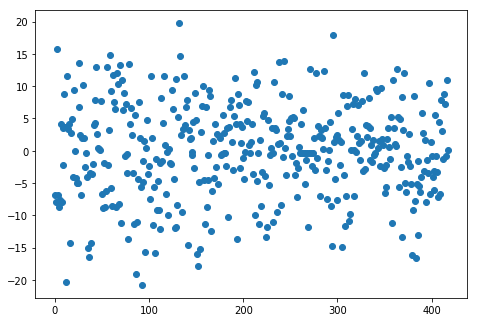

In [731]:
# graph residuals to look for patterns
predictions = myModel.predict(XScaled)
residuals = predictions - y

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(range(len(residuals)), residuals)

In [693]:
# create model using all data points
XScaled = poly.fit_transform(X)
myModel = model.fit(XScaled,y)

0.23088771180373002

In [696]:
# get final coefficients
coeff_dic = {}
n = 0
for coef_ in myModel.coef_:
    if abs(myModel.coef_[n].round(4)) != 0:
        coeff_dic[poly.get_feature_names([col[3], col[7], col[11]])[n]] = myModel.coef_[n].round(4)
        n+=1
    else:
        n+=1
        
print('Ridge Regression Coefficients\nPolynomial Degree 2\nAlpha = 1960')
print('Intercept:', myModel.intercept_.round(4))
print('Total Non-Zero Coefficients: {}\n'.format(len(coeff_dic)))
print(json.dumps(coeff_dic, indent = 1))

Ridge Regression Coefficients
Polynomial Degree 2
Alpha = 1960
Intercept: -0.3534
Total Non-Zero Coefficients: 9

{
 "PCT": -0.0515,
 "INT": 12.4197,
 "AvgYds/Rush": 1.6585,
 "PCT^2": 0.0034,
 "PCT INT": -0.0832,
 "PCT AvgYds/Rush": -0.0137,
 "INT^2": -2.997,
 "INT AvgYds/Rush": -0.6841,
 "AvgYds/Rush^2": 0.0374
}
